In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**net.py**

In [2]:
import torch
import torch.nn as nn


class Net(nn.Module):
    def __init__(self, nb_input=3, nb_output=3):
        # initialize deep-learning network
        super(Net, self).__init__()

        # Layers: enc_conv0, enc_conv1, pool1
        self._block1 = nn.Sequential(
            nn.Conv2d(in_channels=nb_input, out_channels=48, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layers: enc_conv(i), pool(i); i=2..5
        self._block2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layers: enc_conv6, upsample5
        self._block3 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=48, out_channels=48, kernel_size=3, stride=2, padding=1, output_padding=1, dilation=1))
            # nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv5a, dec_conv5b, upsample4
        self._block4 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=96, out_channels=96, kernel_size=3, stride=2, padding=1, output_padding=1, dilation=1))
            # nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
        self._block5 = nn.Sequential(
            nn.Conv2d(in_channels=144, out_channels=96, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=96, out_channels=96, kernel_size=3, stride=2, padding=1, output_padding=1, dilation=1))
            # nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv1a, dec_conv1b, dec_conv1c,
        self._block6 = nn.Sequential(
            nn.Conv2d(in_channels=96 + nb_input, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=nb_output, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.LeakyReLU(negative_slope=0.1))

        # Initialize weights
        # self._init_weights()

    # def _init_weights(self):
    #     """Initializes weights using He et al. (2015)."""
    #
    #     for m in self.modules():
    #         if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight.data)
    #             m.bias.data.zero_()

    def forward(self, input):
        """Through encoder, then decoder by adding U-skip connections. """

        # Encoder
        pool1 = self._block1(input)
        pool2 = self._block2(pool1)
        pool3 = self._block2(pool2)
        pool4 = self._block2(pool3)
        pool5 = self._block2(pool4)

        # Decoder
        upsample5 = self._block3(pool5)
        concat5 = torch.cat((upsample5, pool4), dim=1)
        upsample4 = self._block4(concat5)
        concat4 = torch.cat((upsample4, pool3), dim=1)
        upsample3 = self._block5(concat4)
        concat3 = torch.cat((upsample3, pool2), dim=1)
        upsample2 = self._block5(concat3)
        concat2 = torch.cat((upsample2, pool1), dim=1)
        upsample1 = self._block5(concat2)
        concat1 = torch.cat((upsample1, input), dim=1)
        output = self._block6(concat1)

        # Final activation
        return output

class Net2(nn.Module):
    def __init__(self, nb_input=3, nb_output=3):
        # initialize deep-learning network
        super(Net2, self).__init__()

        self.model = nn.Sequential(
            # encoder
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 8, kernel_size=4, stride=1, padding=0),
            # decoder
            nn.ConvTranspose2d(8, 32, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=1, padding=0)
        )

    def forward(self, input):
        return self.model(input)



**model.py**

In [3]:
import torch
import torch.nn as nn
from torch import optim
# from Miniproject_1.other.net import *
# model.py will be imported by the testing pipeline

class Model():
    def __init__(self, net='Net', lr=1e-4, optimizer='SGD', criterion='MSE', scheduler_gamma=0.8) -> None:
        ## instantiate model + optimizer + loss function + any other stuff you need

        if net == 'Net':
            self.model = Net()
        if net == 'Net2':
            self.model = Net2()

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(self.device)
        self.model.to(self.device)

        self.learning_rate = lr

        if criterion == 'MSE':
            self.criterion = nn.MSELoss()
        if criterion == 'CrossEntropyLoss':
            self.criterion = nn.CrossEntropyLoss()

        if optimizer == 'SGD':
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        if optimizer == 'Adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        if optimizer == 'Adagrad':
            self.optimizer = optim.Adagrad(self.model.parameters(), lr=self.learning_rate)
        if optimizer == 'Adadelta':
            self.optimizer = optim.Adadelta(self.model.parameters(), lr=self.learning_rate)

        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=scheduler_gamma)

    def save_model(self) -> None:
        ## This saves the parameters of the model into bestmodel.pth
        torch.save(self.model.state_dict(), 'Miniproject_1/bestmodel.pth')
        # print('model saved to bestmodel.pth')

    def load_pretrained_model(self) -> None:
        ## This loads the parameters saved in bestmodel.pth into the model
        m_state_dict = torch.load('Miniproject_1/bestmodel.pth')
        self.model.load_state_dict(m_state_dict)
        # print('model loaded')

    def train(self, train_input, train_target, num_epochs=1, mini_batch_size = 20, lambda_l2=0) -> None:
        #: train_input : tensor of size (N, C, H, W) containing a noisy version of the images.
        #: train_target : tensor of size (N, C, H, W) containing another noisy version of the same images, which only differs from the input by their noise.

        train_input, train_target = train_input.to(self.device), train_target.to(self.device)

        train_input = train_input.float().div(255)
        train_target = train_target.float().div(255)

        for e in range(num_epochs):
            for b in range(0, train_input.size(dim=0), mini_batch_size):
                output = self.model(train_input.narrow(dim=0, start=b, length=mini_batch_size))  # takes time
                loss = self.criterion(output, train_target.narrow(dim=0, start=b, length=mini_batch_size))
                self.optimizer.zero_grad()

                # L2 penalty term (to avoid overfitting the training data for an increasing number of epochs)
                for p in self.model.parameters():
                    loss += lambda_l2 * p.pow(2).sum()

                loss.backward()  # takes time
                self.optimizer.step()

            self.scheduler.step()  # decrease learning rate

    def predict(self, test_input) -> torch.Tensor:
        #: test_input : tensor of size (N1 , C, H, W) that has to be denoised by the trained or the loaded network.
        #: returns a tensor of the size (N1 , C, H, W)

        # predicted_output =  torch.empty_like(test_input)

        # test_output = test_input.view(test_input.size(dim=0), -1)
        # predicted_output = torch.argmax(nn.softmax(test_output).data, 1)

        test_input = test_input.to(self.device)

        test_input = test_input.float().div(255)

        predicted_output = self.model(test_input)

        predicted_output = predicted_output.mul(255).to(torch.uint8)

        return predicted_output


**run_miniproject_1.py**

noisy_imgs_train_1 torch.Size([50000, 3, 32, 32]) noisy_imgs_train_2 torch.Size([50000, 3, 32, 32])
noisy_imgs_valid torch.Size([1000, 3, 32, 32]) clean_imgs_valid torch.Size([1000, 3, 32, 32])
cuda:0
mean psnr = 17.01733 dB std psnr = 3.23318 dB


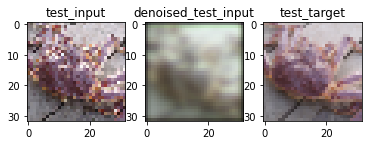

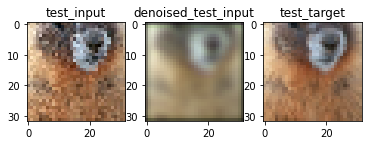

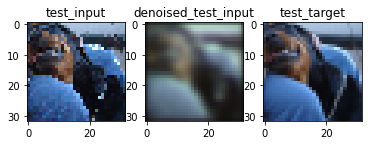

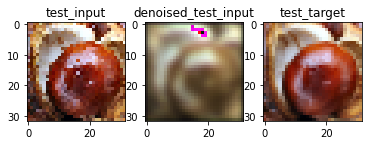

In [5]:
import torch
from torch.utils.data import (DataLoader,)  # Gives easier dataset managment and creates mini batches
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import matplotlib.pyplot as plt

# from Miniproject_1.model import Model

# noisy_imgs_train_1, noisy_imgs_train_2 = torch.load('miniproject_dataset/train_data.pkl')
# noisy_imgs_valid, clean_imgs_valid = torch.load('miniproject_dataset/val_data.pkl')
noisy_imgs_train_1, noisy_imgs_train_2 = torch.load(open('/content/drive/MyDrive/Colab Notebooks/DL colabs/miniproject_dataset/train_data.pkl', 'rb'))
noisy_imgs_valid, clean_imgs_valid = torch.load(open('/content/drive/MyDrive/Colab Notebooks/DL colabs/miniproject_dataset/val_data.pkl', 'rb'))

print('noisy_imgs_train_1', noisy_imgs_train_1.size(), 'noisy_imgs_train_2', noisy_imgs_train_2.size())
print('noisy_imgs_valid', noisy_imgs_valid.size(), 'clean_imgs_valid', clean_imgs_valid.size())


def compute_psnr_mean(x, y):
    assert x.shape == y.shape and x.ndim == 4
    return - 10 * torch.log10(((x-y) ** 2).mean((1,2,3))).mean()

def compute_psnr_std(x, y):
    assert x.shape == y.shape and x.ndim == 4
    return - 10 * torch.log10(((x-y) ** 2).mean((1,2,3))).std()

def plot_images(*args, titles):
    for i in range(args[0].size(dim=0)): # number images to plot for each dataset
        if len(args) > 1: _, axes = plt.subplots(1, len(args))
        for img, idx in zip(args, range(len(args))): # number datasets to plot
            if len(args) > 1:
                axes[idx].imshow(img[i,:,:,:].permute((1, 2, 0)))
                axes[idx].set_title(titles[idx])
            else:
                plt.imshow(img[i, :, :, :].permute((1, 2, 0)))
                plt.title(titles[idx])
        plt.show()

# plot_images(noisy_imgs_train_1[0:4, :, :, :], noisy_imgs_train_2[0:4, :, :, :], titles=['noisy_imgs_train_1','noisy_imgs_train_2'])
# plot_images(noisy_imgs_valid[0:4, :, :, :], clean_imgs_valid[0:4, :, :, :], titles=['noisy_imgs_valid','clean_imgs_valid'])

# # transform data
# my_transforms = transforms.Compose(
#     [   # Compose makes it possible to have many transforms
#         # transforms.ToPILImage(),
#         transforms.Resize((36, 36)),  # Resizes (32,32) to (36,36)
#         transforms.RandomCrop((32, 32)),  # Takes a random (32,32) crop
#         transforms.ColorJitter(brightness=0.5),  # Change brightness of image
#         transforms.RandomRotation(degrees=45),  # Perhaps a random rotation from -45 to 45 degrees
#         transforms.RandomHorizontalFlip(p=0.5),  # Flips the image horizontally with probability 0.5
#         transforms.RandomVerticalFlip(p=0.05),  # Flips image vertically with probability 0.05
#         transforms.RandomGrayscale(p=0.2),  # Converts to grayscale with probability 0.2
#         # transforms.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch
#         # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Note: these values aren't optimal
#     ]
# )
#
# transformed_imgs = my_transforms(noisy_imgs_train_1[0:4, :, :, :])
# plot_images(transformed_imgs, titles=['transformed_imgs'])

################################################################################

#subset of data
train_data_upper_index = 1000
train_input = noisy_imgs_train_1[0:train_data_upper_index, :, :, :]
train_target = noisy_imgs_train_2[0:train_data_upper_index, :, :, :]
test_input = noisy_imgs_valid[0:train_data_upper_index, :, :, :]
test_target = clean_imgs_valid[0:train_data_upper_index, :, :, :]

# model = Model(net='Net', lr=1e-1, optimizer='SGD', criterion='MSE', scheduler_gamma=1)
# model = Model(net='Net', lr=1e-3, optimizer='Adam', criterion='MSE', scheduler_gamma=1)
# model = Model(net='Net', lr=1e-3, optimizer='Adagrad', criterion='MSE', scheduler_gamma=1)
model = Model(net='Net', lr=5e-1, optimizer='Adadelta', criterion='MSE', scheduler_gamma=1)

# train
model.train(train_input, train_target, num_epochs=2, mini_batch_size=20, lambda_l2=0)
# model.save_model()

# load model
# model.load_pretrained_model()

# denoise input
denoised_test_input = model.predict(test_input).cpu().detach()

# PSNR
psnr_mean = float(compute_psnr_mean(denoised_test_input.float().div(255), test_target.float().div(255)))
psnr_std = abs(float(compute_psnr_std(denoised_test_input.float().div(255), test_target.float().div(255))))
print('mean psnr = {:.5f}'.format(psnr_mean),'dB', 'std psnr = {:.5f}'.format(psnr_std),'dB')


# plot denoised image
plot_images(test_input[0:4,:,:,:], denoised_test_input[0:4,:,:,:], test_target[0:4,:,:,:], titles=['test_input','denoised_test_input','test_target'])
